In [1]:
%matplotlib inline
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('ggplot')
mpl.rcParams['axes.facecolor'] = 'white'
# Pour enlever la grille lors des plots
new_style = {'grid': False}
mpl.rc('axes', **new_style)
mpl.rcParams['axes.prop_cycle']

mpl.rcParams['figure.figsize'] = [5,5]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 600

mpl.rcParams['font.size'] = 4

from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7199962311988154089
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 5692129280
locality {
  bus_id: 1
}
incarnation: 2323156280249002882
physical_device_desc: "device: 0, name: GeForce GTX TITAN Black, pci bus id: 0000:02:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 5977505792
locality {
  bus_id: 1
}
incarnation: 16986441134503964241
physical_device_desc: "device: 1, name: GeForce GTX TITAN Black, pci bus id: 0000:03:00.0"
]


In [3]:
# All paths
res_path = '/users/invites/jmorlot/Documents/Sequence_Embedding/'

# Motif State Prediction

## Import Data

In [292]:
f = h5py.File('/home/invites/jmorlot/HDD/Hematopoiesis/Results/matrixCT.hdf5','r')
matrixCT = np.array(f[f.keys()[0]])
f.close()

In [5]:
sequence = np.load('/home/invites/jmorlot/HDD/Sequence/Sequence.npy')

In [58]:
# f = open('/home/invites/jmorlot/HDD/Hematopoiesis/Results/Names_Combinaisons_sorted.txt','r')
# names = np.array([n for n in f])
# f.close()
# #We remove the zeros state
# names = names[2:51]
# names = np.array([(n.split('\t')[1]).split('\n')[0] for n in names])

In [293]:
names_CT = np.load('/home/invites/jmorlot/HDD/Hematopoiesis/names_CT2.npy')

In [7]:
# idxS = np.argsort(StateMatrix.sum(axis=1))[::-1]

In [259]:
# #We remove the zeros state
# StateMatrix = StateMatrix[1:,:]

In [201]:
# StateMatrix = StateMatrix[3:19,:]
# names = names[3:19]

In [294]:
import Sequence_embedding_function as SEF
reload(SEF)
# xtrain,ytrain,xtest,ytest = SEF.get_dataset(StateMatrix,sequence,split_train=0.8)
xtrain,ytrain,xtest,ytest = SEF.get_dataset_CT(matrixCT,sequence,split_train=0.8)
# xtrain,ytrain,xtest,ytest = SEF.get_dataset_all_states(StateMatrix,sequence,split_train=0.8,uniformisation=False)

Input Sequence
Transpose matrix in order to get the batch dimension first


In [295]:
print 'Data Memory Occupancy: ' + str(round(np.prod(xtrain.shape)*32/1e9+np.prod(ytrain.shape)*32/1e9,2)) + ' Go'

Data Memory Occupancy: 1.92 Go


In [296]:
print xtrain.shape
print xtest.shape
print ytrain.shape
print ytest.shape
# print np.concatenate(xtrain,axis=0).shape

(73921, 200, 4)
(18481, 200, 4)
(73921, 13)
(18481, 13)


In [267]:
ytrain.sum(axis=0)

array([ 50213.,  50318.])

## Model

In [268]:
reload(SEF)

<module 'Sequence_embedding_function' from 'Sequence_embedding_function.pyc'>

In [301]:
from keras.layers.pooling import GlobalMaxPooling1D,MaxPooling1D
from keras.layers.core import Dropout,Flatten,Reshape,Activation,ActivityRegularization
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.convolutional import Conv1D
from keras.constraints import non_neg
from keras.layers.embeddings import Embedding

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

class CNN_States:
    
    def __init__(self,NState,MotifLen,Nmotif,NHidden,LearningRate,Momentum,DropoutRate,NEmb,l1_reg=0,optimizer='rmsprop',SeqLen=200,validation_split=0.12):
        self.NState = NState
        self.MotifLen = MotifLen
        self.Nmotif = Nmotif
        self.NHidden = NHidden
        self.LearningRate = LearningRate
        self.Momentum = Momentum
        self.validation_split = validation_split
        self.SeqLen = SeqLen
        self.DropoutRate = DropoutRate
        self.optimizer = optimizer
        self.l1_reg = l1_reg
        self.NEmb = NEmb
        
        #Accuracy & Loss
        self.loss=[]
        self.accuracy=[]
        self.kappa=[]
        self.scores_iter=[]
        self.loss_class = []
        self.accuracy_class = []
        
        #Best accuracy on validation set model
        self.best_model=[]
        self.best_kappa = 0
        
        #Layers
        self.model = []
        self.modelMP3F = []
        
        #Other parameters
        self.class_weight = 0
        self.current_epoch = 0
    
    def build_model(self):
        sequence_input = Input(shape=(self.SeqLen,4))
        
        #CNN == One Hot encoding
        conv = Conv1D(self.Nmotif,self.MotifLen, activation='relu',padding='same')(sequence_input)
        convMP = MaxPooling1D(pool_size=4)(conv)
        conv2 = Conv1D(self.Nmotif/2,self.MotifLen, activation='relu',padding='same')(convMP)
#         convMP2 = MaxPooling1D(pool_size=4)(conv2)
#         conv3 = Conv1D(self.Nmotif/4,self.MotifLen, activation='relu',padding='same')(convMP2)
#         convMP3 = MaxPooling1D(pool_size=2)(conv3)
#         conv4 = Conv1D(self.Nmotif/8,self.MotifLen, activation='relu',padding='same')(convMP3)
#         convMP4 = MaxPooling1D(pool_size=2)(conv4)
        
        
#         GlMP = Reshape((self.Nmotif,))(GlMP)
#         GlMP = ActivityRegularization(l1=self.l1_reg)(GlMP)
#         GlMPE = Dense(self.NEmb, activation='linear')(GlMPR)
#         GlMP = Activation("linear")(GlMP)
    
#         GlMPE = Embedding(self.Nmotif,self.NEmb)(GlMP)
        convMP2F = GlobalMaxPooling1D()(conv2)
#         convMP2F = Flatten()(convMP2)
#         GlMPE = Embedding(self.Nmotif,self.NEmb)(GlMP)
        
#         GlMP = Dense(self.Nmotif, activation='softmax')(GlMP)
        
        hidd_layer = Dense(self.NHidden, activation='relu')(convMP2F)
        hidd_layerD = Dropout(self.DropoutRate)(hidd_layer)
        states = Dense(self.NState, activation='softmax')(hidd_layerD)
        
        self.model = Model(sequence_input, states)
        self.model.compile(loss='categorical_crossentropy',optimizer=self.optimizer,metrics=['accuracy'])
        
        
    def build_OHEmodel(self):
        #Get motif activation == OneHotEncoding
        sequence_input = Input(shape=(self.SeqLen,4))
        
        #CNN == One Hot encoding
        conv = Conv1D(self.Nmotif,self.MotifLen, activation='relu',padding='same',weights=self.best_model.layers[1].get_weights())(sequence_input)
        convMP = MaxPooling1D(pool_size=4)(conv)
        conv2 = Conv1D(self.Nmotif/2,self.MotifLen, activation='relu',padding='same',weights=self.best_model.layers[3].get_weights())(convMP)
        convMP2 = MaxPooling1D(pool_size=4)(conv2)
        
#         conv3 = Conv1D(self.Nmotif/4,self.MotifLen, activation='relu',padding='same',weights=self.best_model.layers[5].get_weights())(convMP2)
#         convMP3 = MaxPooling1D(pool_size=2)(conv3)
#         conv4 = Conv1D(self.Nmotif/8,self.MotifLen, activation='relu',padding='same',weights=self.best_model.layers[7].get_weights())(convMP3)
#         convMP4 = MaxPooling1D(pool_size=2)(conv4)
        
#         convMP2F = GlobalMaxPooling1D()(conv2)
        convMP2F = Flatten()(convMP2)
        
        hidd_layer = Dense(self.NHidden, activation='relu')(convMP2F)
        hidd_layerD = Dropout(self.DropoutRate)(hidd_layer)
        states = Dense(self.NState, activation='softmax')(hidd_layerD)
        
        #model conv
#         self.modelConv = Model(sequence_input, conv)
#         self.modelConv.compile(loss='binary_crossentropy',optimizer=self.optimizer,metrics=['accuracy'])
        
        self.modelMP3F = Model(sequence_input, convMP2F)
        self.modelMP3F.compile(loss='categorical_crossentropy',optimizer=self.optimizer,metrics=['accuracy'])
        
        
    def fit(self,xtrain,ytrain,epochs_all=50,epochs=5,batch_size=128):
        
        xval,yval,xtrain,ytrain = self.get_validation_set(xtrain,ytrain,split_val=self.validation_split)
        
        #Uniformization of the training set
#         xtrain,ytrain = SEF.Uniformisation(xtrain,ytrain)
        
        #Compensing class imbalancing when classifying states
        labels_train = ytrain.argmax(axis=1)
        self.class_weight = class_weight.compute_class_weight('balanced', np.unique(labels_train), labels_train)
        
        #Fitting
        NEpochs = epochs_all/epochs
        
        Nbatch = int(np.floor(xtrain.shape[0]/float(batch_size)))
        
        for i in range(NEpochs):
            self.current_epoch = self.current_epoch + int(epochs)
            print '\nCurrent Epoch = ' + str(self.current_epoch)
            self.model.fit_generator(generator = self.train_generator(xtrain,ytrain,batch_size), 
                                     epochs=epochs,steps_per_epoch=Nbatch,class_weight=self.class_weight)
            print 'Evaluate the model on validataion set'
            self.evaluate(xval,yval)
            
        
        
    def evaluate(self,xtest,ytest):
        loss,accuracy = self.model.evaluate(xtest,ytest, verbose=0)
        ypred = self.model.predict(xtest)
        kappa = cohen_kappa_score(ytest.argmax(axis=1), ypred.argmax(axis=1))
        print 'loss = ' + str(loss)
        print 'accuracy = ' + str(accuracy)
        print 'kappa = ' + str(kappa)
        
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.kappa.append(kappa)
        self.scores_iter.append(self.current_epoch)
        
        #score for each class
        loss_class_i = [None]*ytest.shape[1]
        accuracy_class_i = [None]*ytest.shape[1]
        kappa_class_i = [None]*ytest.shape[1]
        for i in range(ytest.shape[1]):
            idx1 = np.where(ytest[:,i]>0)[0]
            loss_class_i[i],accuracy_class_i[i] = self.model.evaluate(xtest[idx1],ytest[idx1], verbose=0)
        
        self.loss_class.append(loss_class_i)
        self.accuracy_class.append(accuracy_class_i)
        
        
        if kappa > self.best_kappa:
            self.best_kappa = kappa
            self.best_model = self.model
        
    def get_validation_set(self,xtrain,ytrain,split_val=0.12):
        N1 = xtrain.shape[0]
        idxR = np.random.permutation(N1)

        N1_val = int(N1*split_val)
        xval = xtrain[idxR[:N1_val],:,:]
        yval = ytrain[idxR[:N1_val],:]

        xtrain_Batch = xtrain[idxR[N1_val:],:,:]
        ytrain_Batch = ytrain[idxR[N1_val:],:]

        return xval,yval,xtrain_Batch,ytrain_Batch
    
    def train_generator(self,xtrain,ytrain,batch_size):
            Nbatch = int(np.floor(xtrain.shape[0]/float(batch_size)))
            while True:
                idxR = np.random.permutation(xtrain.shape[0])
                for i in range(Nbatch):
                    yield xtrain[idxR[(i*batch_size):((i+1)*batch_size)],:,:],ytrain[idxR[(i*batch_size):((i+1)*batch_size)],:]


In [309]:
modelCNN = CNN_States(NState=13,
                   MotifLen=15,
                   Nmotif=32,
                   NHidden=30,
                   LearningRate=5e-2,
                   Momentum=0.97,
                   DropoutRate=0,
                   l1_reg=0,
                   NEmb=32,
                   optimizer='adadelta',
                   SeqLen=200,
                   validation_split=0.12)

In [310]:
modelCNN.build_model()

In [311]:
modelCNN.fit(xtrain=xtrain,ytrain=ytrain,epochs_all=2000,epochs=5,batch_size=128)


Current Epoch = 5
Epoch 1/5
508/508 [==============================] - 3s - loss: 11.7921 - acc: 0.0721     
Epoch 2/5
508/508 [==============================] - 2s - loss: 11.7759 - acc: 0.0789     
Epoch 3/5
508/508 [==============================] - 2s - loss: 11.7726 - acc: 0.0851     
Epoch 4/5
508/508 [==============================] - 2s - loss: 11.7717 - acc: 0.0846     
Epoch 5/5
508/508 [==============================] - 2s - loss: 11.7698 - acc: 0.0858     
Evaluate the model on validataion set
loss = 11.5430350773
accuracy = 0.0658399098083
kappa = -0.00130080733268

Current Epoch = 10
Epoch 1/5
508/508 [==============================] - 3s - loss: 11.7691 - acc: 0.0840     
Epoch 2/5
508/508 [==============================] - 2s - loss: 11.7659 - acc: 0.0868     
Epoch 3/5
508/508 [==============================] - 2s - loss: 11.7624 - acc: 0.0872     
Epoch 4/5
508/508 [==============================] - 2s - loss: 11.7601 - acc: 0.0910     
Epoch 5/5
508/508 [===========


Current Epoch = 75
Epoch 1/5
508/508 [==============================] - 2s - loss: 11.5836 - acc: 0.0907     
Epoch 2/5
508/508 [==============================] - 2s - loss: 11.5858 - acc: 0.0910     
Epoch 3/5
508/508 [==============================] - 2s - loss: 11.5824 - acc: 0.0904     
Epoch 4/5
508/508 [==============================] - 2s - loss: 11.5821 - acc: 0.0898     
Epoch 5/5
508/508 [==============================] - 2s - loss: 11.5811 - acc: 0.0916     
Evaluate the model on validataion set
loss = 11.7717464011
accuracy = 0.0705749718151
kappa = 0.0039135786503

Current Epoch = 80
Epoch 1/5
508/508 [==============================] - 2s - loss: 11.5778 - acc: 0.0914     
Epoch 2/5
508/508 [==============================] - 2s - loss: 11.5776 - acc: 0.0909     
Epoch 3/5
508/508 [==============================] - 2s - loss: 11.5774 - acc: 0.0905     
Epoch 4/5
508/508 [==============================] - 2s - loss: 11.5723 - acc: 0.0909     
Epoch 5/5
508/508 [============


Current Epoch = 145
Epoch 1/5
508/508 [==============================] - 2s - loss: 11.5172 - acc: 0.0896     
Epoch 2/5
508/508 [==============================] - 2s - loss: 11.5180 - acc: 0.0890     
Epoch 3/5
 10/508 [..............................] - ETA: 2s - loss: 11.4766 - acc: 0.0891

KeyboardInterrupt: 

In [312]:
modelCNN.build_OHEmodel()

In [313]:
# reload(SEF)

# Nparam = 100
# modelsCNN = []

# params = generate_param_CNN_States(Nparam)

# for i in range(Nparam):

#     modelsCNN.append(CNN_States(NState=2,
#                       MotifLen=params[i]['MotifLen'],
#                       Nmotif=params[i]['Nmotif'],
#                       NHidden=params[i]['NHidden'],
#                       LearningRate=params[i]['LearningRate'],
#                       Momentum=params[i]['Momentum'],
#                       DropoutRate=params[i]['DropoutRate'],
#                       optimizer='rmsprop',
#                       SeqLen=200,
#                       validation_split=0.12)
#                     )

#     modelsCNN[i].build_model()

#     modelsCNN[i].fit(xtrain=xtrain,ytrain=ytrain,epochs_all=50,epochs=5,batch_size=params[i]['DropoutRate'])

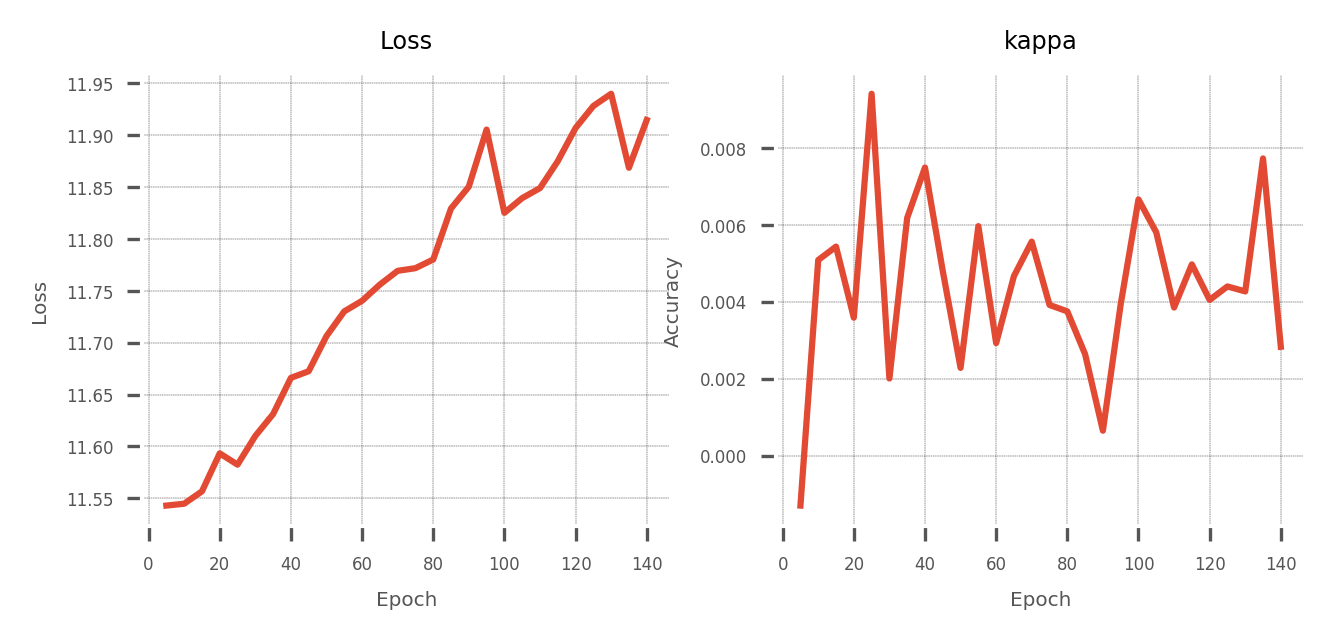

In [314]:
f,ax = plt.subplots(1,2,figsize=(5,2))
ax[0].plot(modelCNN.scores_iter,modelCNN.loss)
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(color='k',lw=0.1,ls='--')

ax[1].plot(modelCNN.scores_iter,modelCNN.kappa)
# ax[1].set_ylim([0,1])
ax[1].set_title('kappa')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].grid(color='k',lw=0.1,ls='--')


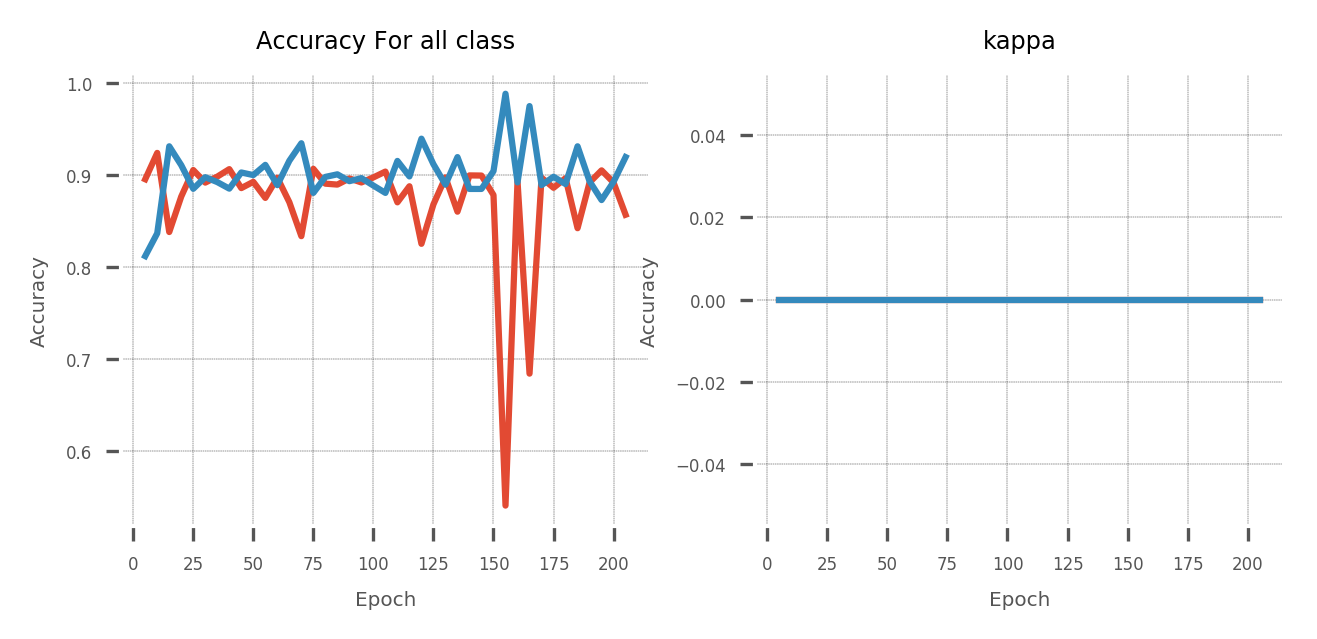

In [276]:
f,ax = plt.subplots(1,1,figsize=(5,2))
ax[0].plot(modelCNN.scores_iter,np.array(modelCNN.accuracy_class))
ax[0].set_title('Accuracy For all class')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].grid(color='k',lw=0.1,ls='--')
# ax[1].legend()

In [277]:
loss,accuracy = modelCNN.best_model.evaluate(xtest,ytest, verbose=0)
#Kappa
ypred = modelCNN.best_model.predict(xtest)
kappa = cohen_kappa_score(ytest.argmax(axis=1), ypred.argmax(axis=1))
print 'loss = ' + str(loss)
print 'accuracy = ' + str(accuracy)
print 'kappa = ' + str(kappa)


loss = 0.885783959202
accuracy = 0.895873950616
kappa = 0.791719684449


In [278]:
from sklearn.metrics import roc_auc_score

ypred = modelCNN.best_model.predict(xtest)
AUC = roc_auc_score(ytest, ypred)
print 'AUC = ' + str(AUC)


AUC = 0.955401757623


In [563]:
# import cPickle
modelCNN.best_model.save(res_path+ 'modelCNN_bestmodel_3layers_18States_128Motifs.h5')
modelCNN.modelMP3F.save(res_path+ 'modelCNN_modelMP3F_3layers_18States_128Motifs.h5')
# cPickle.dump(modelCNN, open(res_path+ 'modelCNN_bestmodel_3layers_18States.pkl', "wb"))

In [279]:
#Evaluate per label
num_site = StateMatrix.sum(axis=1)

acc_state = [None]*ytest.shape[1]
loss_state = [None]*ytest.shape[1]
for i in range(ytest.shape[1]):
    idx1 = np.where(ytest[:,i]>0)[0]
    loss_state[i],acc_state[i] = modelCNN.best_model.evaluate(xtest[idx1],ytest[idx1], verbose=0)
    
    print names[i] + ' | accuracy = ' + str(acc_state[i]) + ' | Num.Site = ' + str(num_site[i])

B | accuracy = 0.910373246691 | Num.Site = 13545.0
CD8 | NK | accuracy = 0.881252996644 | Num.Site = 7586.0


ValueError: x and y must be the same size

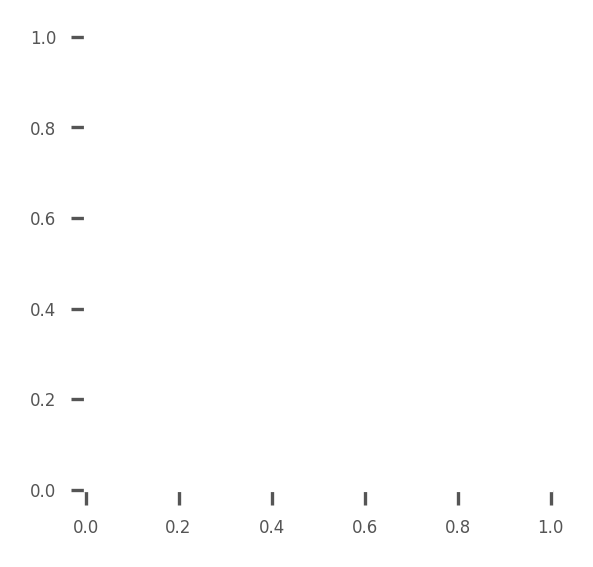

In [280]:
f,ax = plt.subplots(1,1,figsize=(2,2))
ax.scatter(np.array(acc_state),num_site,s=2)
ax.grid(color='k',lw=0.1,ls='--')
plt.show()

# Motif Analysis (Need Backgroud identification /!\ )

In [283]:
modelCNN.best_model.layers[0]

In [274]:
CNN1D = modelCNN.best_model.layers[11]
CNN1D = CNN1D.get_weights()

IndexError: list index out of range

In [291]:
Filters = np.transpose(CNN1D[0],(2,1,0))

In [299]:
print ((Filters - Filters.mean(axis=1))/Filters.std(axis=1)).max(axis=1)

[[ 1.56455219  1.49354041  1.12654626  1.47449005  1.02756572  1.58417797
   1.42230666  0.68620598  1.07105625  0.95629525  1.5668534   1.39373505
   1.04457581  1.43006372  1.4208262   1.36161888  0.8533237   1.34981525
   1.44815385  1.67536914  1.43363547  1.25411046  0.9995268   1.19357693]]


In [281]:
ypred = modelCNN.best_model.predict(xtest)
MP3F = modelCNN.modelMP3F.predict(xtest)
print MP3F.shape,ypred.shape

(25133, 64) (25133, 2)


In [74]:
idx0 = np.where(ytest[:,0]>0)[0]
idx1 = np.where(ytest[:,1]>0)[0]

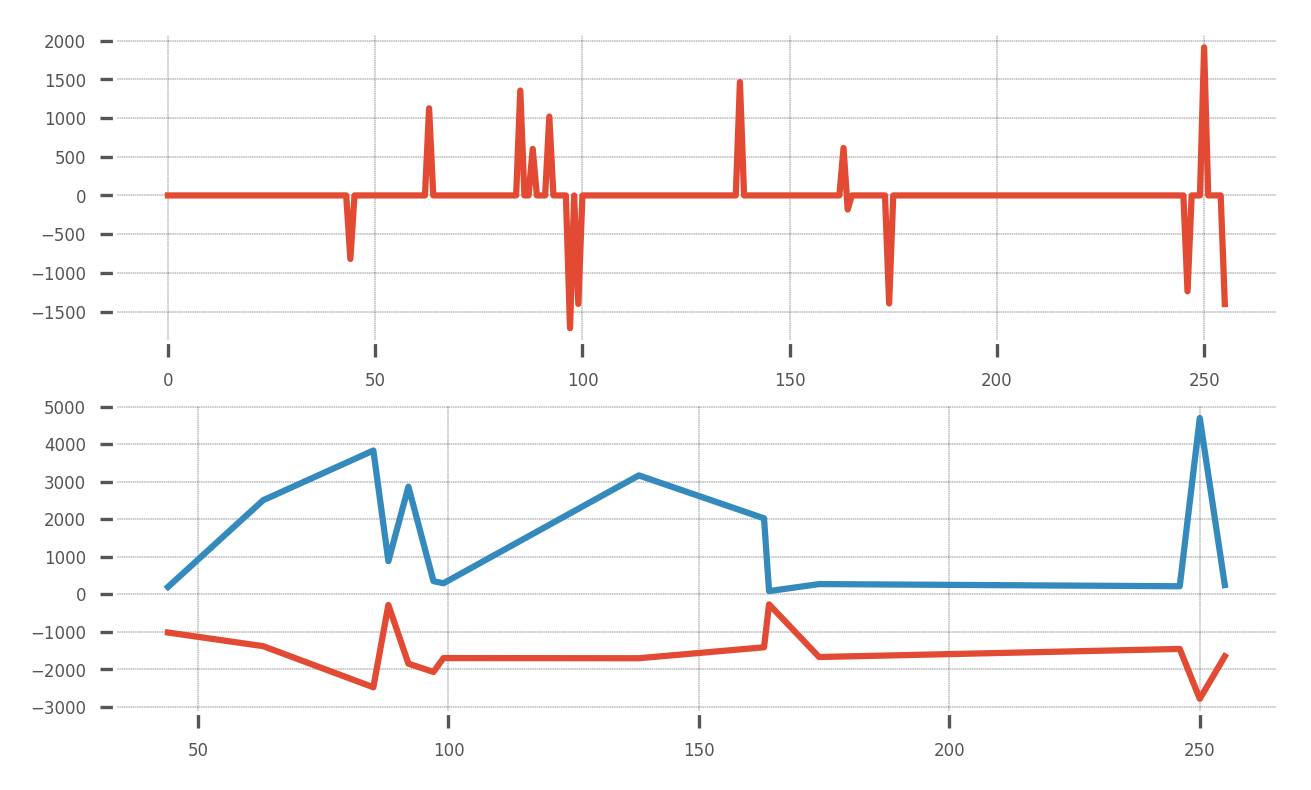

In [77]:
l0,c0 = np.unique(GlMP[idx0,:].argmax(axis=1),return_counts=True)
l1,c1 = np.unique(GlMP[idx1,:].argmax(axis=1),return_counts=True)
counts = np.zeros(GlMP.shape[1])
counts[l1] = c1
counts[l0] = counts[l0] - c0
f,ax = plt.subplots(2,1,figsize=(5,3))
ax[0].plot(counts)
ax[0].grid(color='k',lw=0.1,ls='--')
ax[1].plot(l0,-c0)
ax[1].plot(l1,c1)
ax[1].grid(color='k',lw=0.1,ls='--')
plt.show()
# plt.plot(l1,-c1)

## Find Consencus motif per filters

# Motif Embedding

In [802]:
ytest.shape

(15673, 18)

In [283]:
idx_pred = np.where(ytest.argmax(axis=1)==ypred.argmax(axis=1))[0][:1000]
# idx_pred = np.arange(1000)
# idxR = np.random.permutation(ypred.shape[0])[:1000]

In [284]:
print 'Proportion of site Well Classified in Test set : ' + str((ytest.argmax(axis=1)==ypred.argmax(axis=1)).sum()/float(ytest.shape[0])*100) + ' %'

Proportion of site Well Classified in Test set : 89.5873950583 %


In [285]:
from sklearn.metrics.pairwise import cosine_distances 
# m = MP3F[:,idx_acc]
D = cosine_distances(MP3F[idx_pred,:])
# D = cosine_distances(MP3F[idxR[:1000],:])

In [286]:
D.shape

(1000, 1000)

In [287]:
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=0.2, min_samples=5, metric='precomputed')
labels = DB.fit_predict(D)

In [288]:
labels.max()

0

In [250]:
figure_folder = '/users/invites/jmorlot/Documents/Sequence_Embedding/Figures/'

513 B
487 CD8 | NK


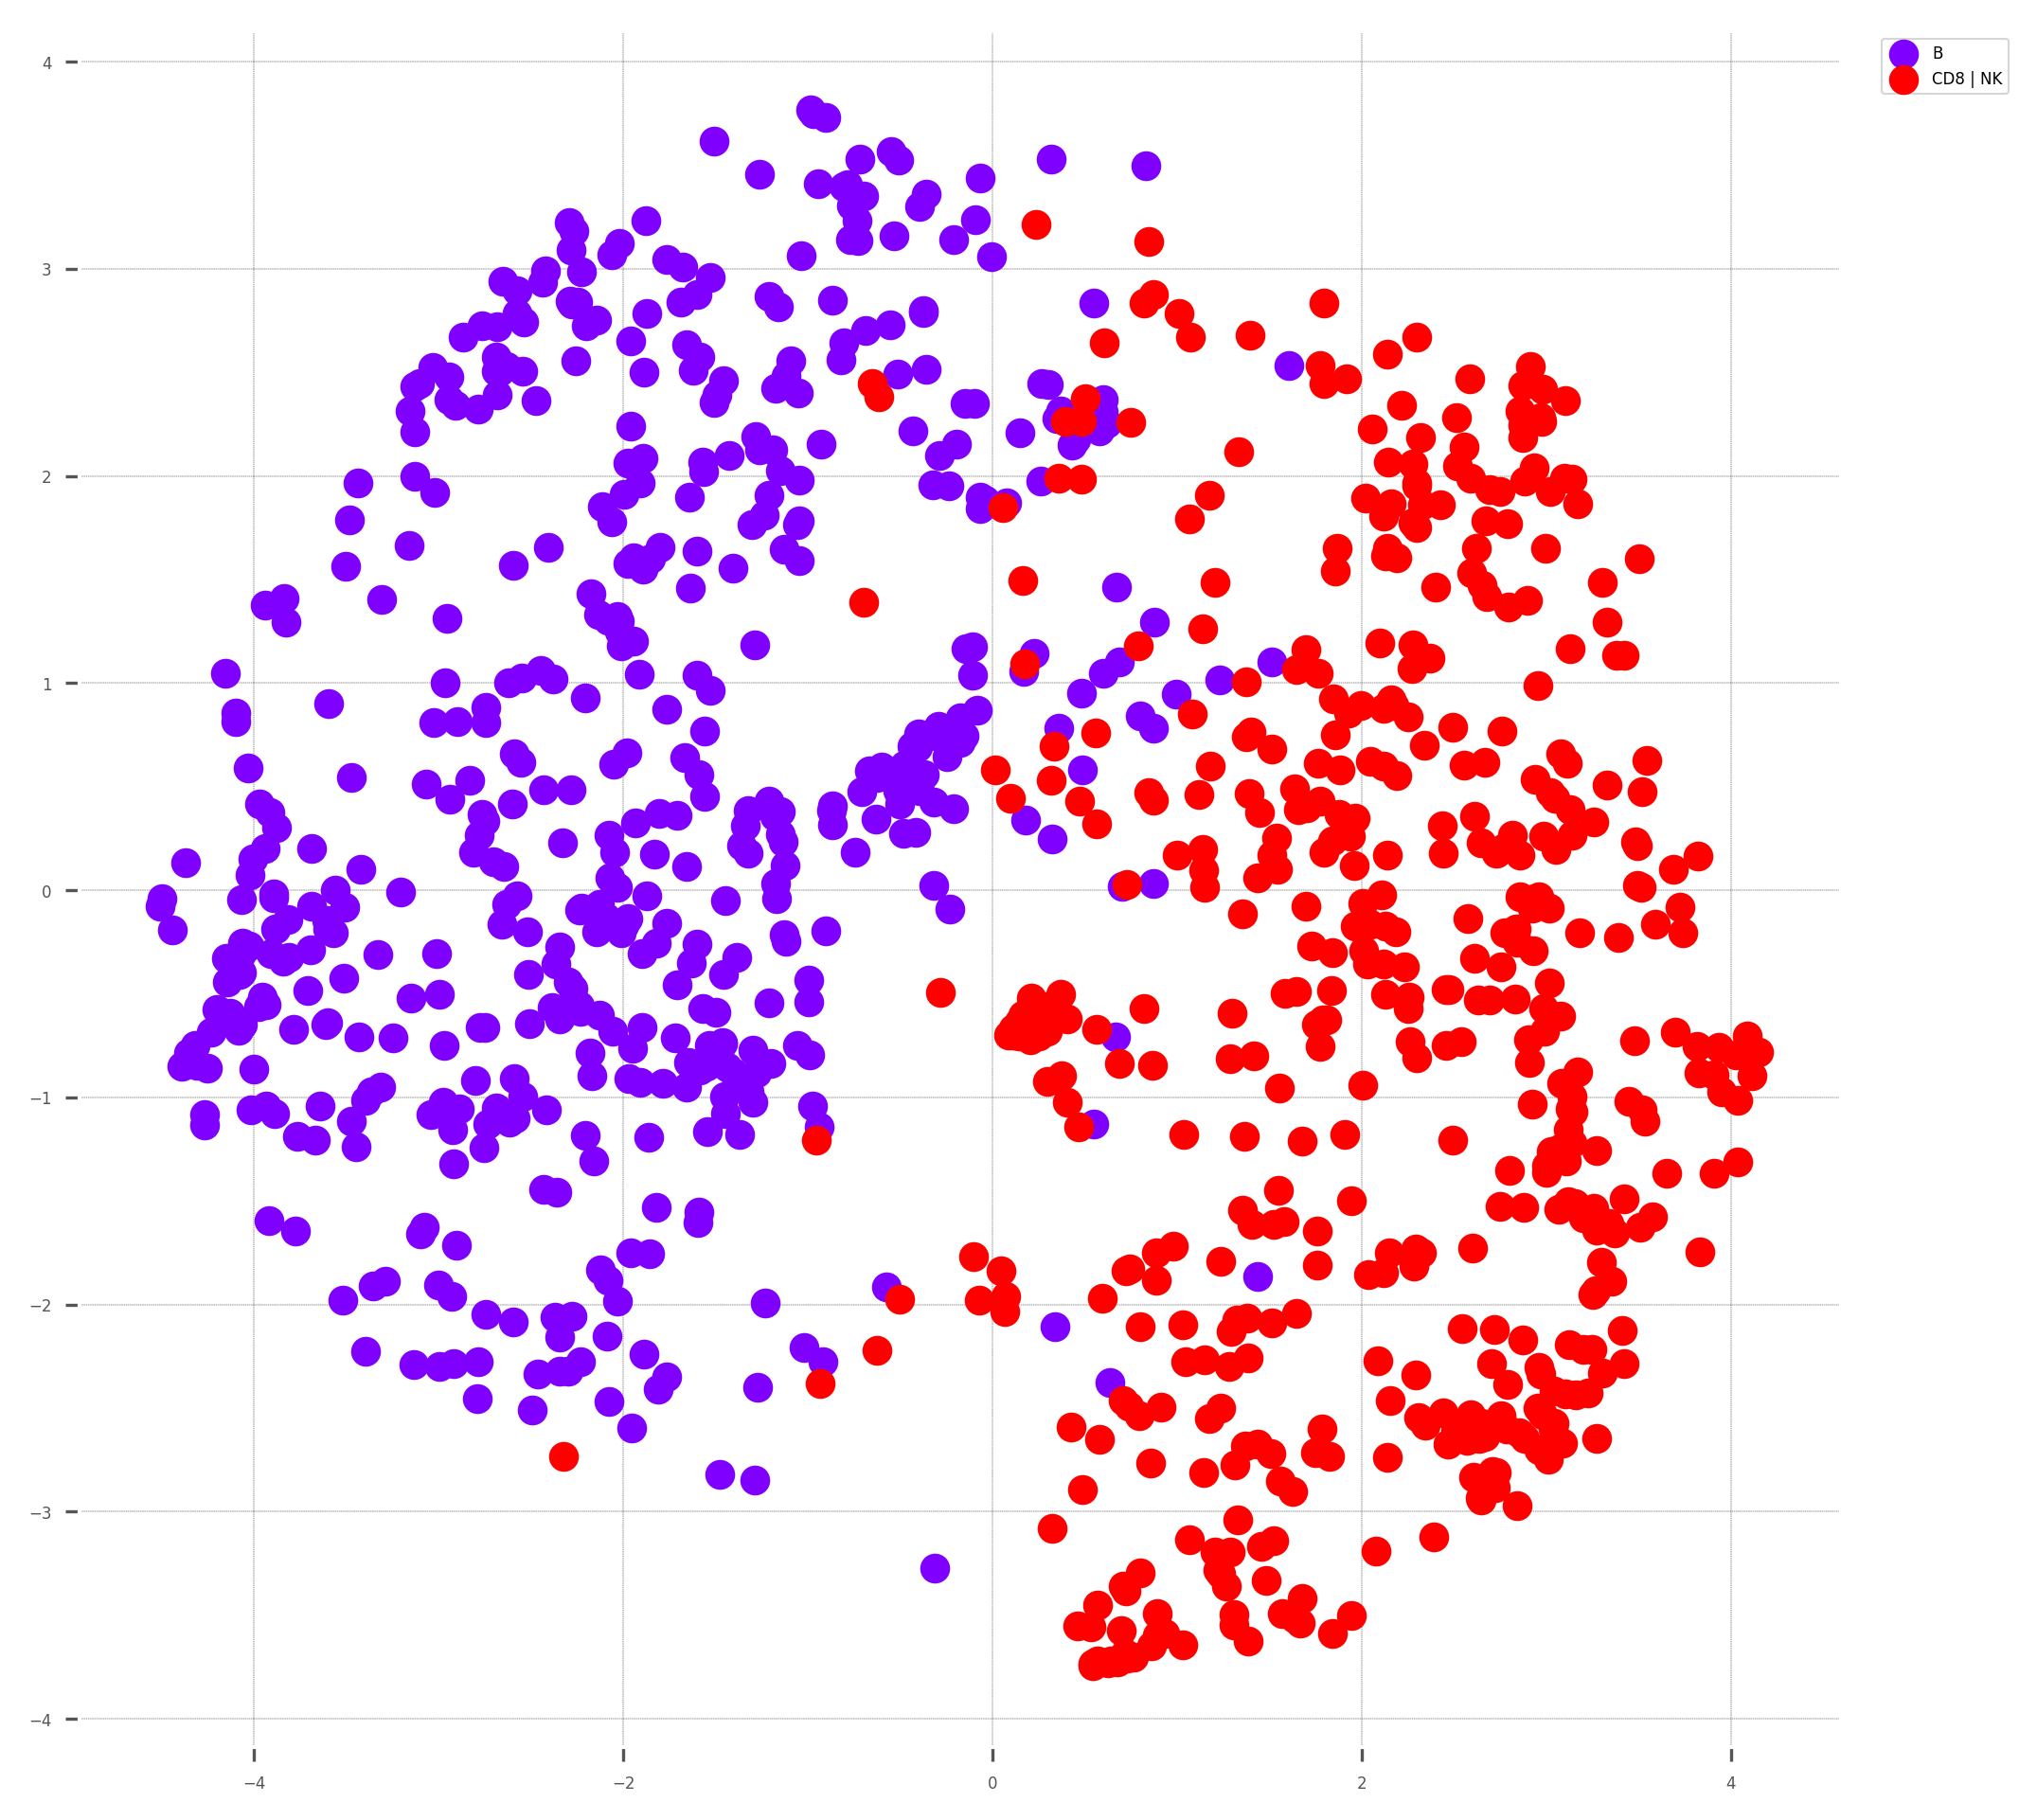

In [291]:
from sklearn import manifold
from matplotlib.pyplot import cm 

# model_tsne = manifold.TSNE(n_components=2, random_state=2,perplexity=10, 
#      early_exaggeration=10.0, learning_rate=1, 
#      n_iter=1000, metric='precomputed')
model_tsne = manifold.TSNE(n_components=2,perplexity=30, random_state=3, 
                           learning_rate=50,n_iter=1000000, metric='precomputed')
# model_MDS = manifold.MDS(n_components=2, dissimilarity='precomputed')

DR = model_tsne.fit_transform(D)
# DR = model_MDS.fit_transform(D)


fig, ax = plt.subplots(figsize=(8,8))
labels = ypred[idx_pred].argmax(axis=1)
# labels = ypred[idxR].argmax(axis=1)
labels_unique,counts = np.unique(labels,return_counts=True)
for i,n in enumerate(names[labels_unique]):
    print counts[i],n
# labels_unique = np.unique(ytest[idxR[:1000]].argmax(axis=1))

color=cm.rainbow(np.linspace(0,1,len(labels_unique)))
for i,l in enumerate(labels_unique):
    ax.scatter(DR[labels==l,0],DR[labels==l,1],c=color[i],s=50,label=names[l])
#     ax.scatter(DR[ytest[idxR,l]>0,0],DR[ytest[idxR,l]>0,1],c=color[i],s=50,label=names[l])
    
ax.grid(color='k',linestyle='--',linewidth=0.1)  
ax.legend(bbox_to_anchor=(1.1, 1))
# plt.savefig(figure_folder + 'TSNE_3_layers_128_only_good_predicted_ytest.png',format='png',dpi=600)
plt.show()

## Import Data

In [24]:
import Sequence_embedding_function as SEF
reload(SEF)
xtrain,ytrain,xtest,ytest = SEF.get_dataset(StateMatrix,sequence,split_train=0.8)

Input Sequence
Including a zeros state with reshuffled bases
Building Null model
Concatenation
Transpose matrix in order to get the batch dimension first


In [25]:
print 'Data Memory Occupancy: ' + str(round(np.prod(xtrain.shape)*32/1e9+np.prod(ytrain.shape)*32/1e9,2)) + ' Go'

Data Memory Occupancy: 4.45 Go


In [26]:
print xtrain.shape
# print np.concatenate(xtrain,axis=0).shape

(173289, 200, 4)


In [27]:
ytrain.sum(axis=0)

array([ 86611.,  86678.])

## Model

In [57]:
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.core import Dropout,Flatten,Reshape,Activation,ActivityRegularization
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.convolutional import Conv1D
from keras.constraints import non_neg

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

class CNN_States:
    
    def __init__(self,NState,MotifLen,Nmotif,NSeq,NHidden,LearningRate,Momentum,DropoutRate,l1_reg,optimizer='rmsprop',SeqLen=200,validation_split=0.12):
        self.NState = NState
        self.MotifLen = MotifLen
        self.Nmotif = Nmotif
        self.NHidden = NHidden
        self.LearningRate = LearningRate
        self.Momentum = Momentum
        self.validation_split = validation_split
        self.SeqLen = SeqLen
        self.NSeq = NSeq
        self.DropoutRate = DropoutRate
        self.optimizer = optimizer
        self.l1_reg = l1_reg
        
        #Accuracy & Loss
        self.loss=[]
        self.accuracy=[]
        self.kappa=[]
        self.scores_iter=[]
        
        #Best accuracy on validation set model
        self.best_model=[]
        self.best_kappa = 0
        
        #Layers
        self.model = []
        self.modelConv = []
        self.modelGlMP = []
        
        #Other parameters
        self.class_weight = 0
        self.current_epoch = 0
    
    def build_model(self):
        sequence_input = Input(shape=(self.NSeq,self.SeqLen,4))
        
        #CNN == One Hot encoding
        conv = Conv1D(self.Nmotif,self.MotifLen, activation='relu',padding='same')(sequence_input)
        GlMP = GlobalMaxPooling1D()(conv)
        
        GlMP = Reshape((self.Nmotif,))(GlMP)
        GlMPR = ActivityRegularization(l1=self.l1_reg)(GlMP)
        
        hidd_layer = Dense(self.NHidden, activation='relu')(GlMPR)
        hidd_layerD = Dropout(self.DropoutRate)(hidd_layer)
        states = Dense(self.NState, activation='softmax')(hidd_layerD)
        
        self.model = Model(sequence_input, states)
        self.model.compile(loss='binary_crossentropy',optimizer=self.optimizer,metrics=['accuracy'])
        
        
    def build_OHEmodel(self):
        #Get motif activation == OneHotEncoding
        sequence_input = Input(shape=(self.SeqLen,4))
        
        #CNN == One Hot encoding
        conv = Conv1D(self.Nmotif,self.MotifLen, activation='relu',padding='same',weights=self.best_model.layers[1].get_weights())(sequence_input)
        GlMP = GlobalMaxPooling1D()(conv)
        
        GlMP = Reshape((self.Nmotif,))(GlMP)
        GlMPR = ActivityRegularization(l1=self.l1_reg)(GlMP)
        
        hidd_layer = Dense(self.NHidden, activation='relu')(GlMPR)
        hidd_layerD = Dropout(self.DropoutRate)(hidd_layer)
        states = Dense(self.NState, activation='softmax')(hidd_layerD)
        
        #model conv
        self.modelConv = Model(sequence_input, conv)
        self.modelConv.compile(loss='binary_crossentropy',optimizer=self.optimizer,metrics=['accuracy'])
        
        self.modelGlMP = Model(sequence_input, GlMPR)
        self.modelGlMP.compile(loss='binary_crossentropy',optimizer=self.optimizer,metrics=['accuracy'])
        
        
    def fit(self,xtrain,ytrain,epochs_all=50,epochs=5,batch_size=128):
        
        xval,yval,xtrain,ytrain = self.get_validation_set(xtrain,ytrain,split_val=self.validation_split)
        
        #Compensing class imbalancing when classifying states
        labels_train = ytrain.argmax(axis=1)
        self.class_weight = class_weight.compute_class_weight('balanced', np.unique(labels_train), labels_train)
        
        #Fitting
        NEpochs = epochs_all/epochs
        
        Nbatch = int(np.floor(xtrain.shape[0]/float(batch_size)))
        
        for i in range(NEpochs):
            self.current_epoch = self.current_epoch + int(epochs)
            print '\nCurrent Epoch = ' + str(self.current_epoch)
            self.model.fit_generator(generator = self.train_generator(xtrain,ytrain,batch_size), 
                                     epochs=epochs,steps_per_epoch=Nbatch,class_weight=self.class_weight)
            print 'Evaluate the model on validataion set'
            self.evaluate(xval,yval)
            
        
        
    def evaluate(self,xtest,ytest):
        loss,accuracy = self.model.evaluate(xtest,ytest, verbose=0)
        ypred = self.model.predict(xtest)
        kappa = cohen_kappa_score(ytest.argmax(axis=1), ypred.argmax(axis=1))
        print 'loss = ' + str(loss)
        print 'accuracy = ' + str(accuracy)
        print 'kappa = ' + str(kappa)
        
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.kappa.append(kappa)
        self.scores_iter.append(self.current_epoch)
        
        if kappa > self.best_kappa:
            self.best_kappa = kappa
            self.best_model = self.model
        
    def get_validation_set(self,xtrain,ytrain,split_val=0.12):
        N1 = xtrain.shape[0]
        idxR = np.random.permutation(N1)

        N1_val = int(N1*split_val)
        xval = xtrain[idxR[:N1_val],:,:]
        yval = ytrain[idxR[:N1_val],:]

        xtrain_Batch = xtrain[idxR[N1_val:],:,:]
        ytrain_Batch = ytrain[idxR[N1_val:],:]

        return xval,yval,xtrain_Batch,ytrain_Batch
    
    def train_generator(self,xtrain,ytrain,batch_size):
            Nbatch = int(np.floor(xtrain.shape[0]/float(batch_size)))
            while True:
                idxR = np.random.permutation(xtrain.shape[0])
                for i in range(Nbatch):
                    yield xtrain[idxR[(i*batch_size):((i+1)*batch_size)],:,:],ytrain[idxR[(i*batch_size):((i+1)*batch_size)],:]


In [65]:
modelCNN = CNN_States(NState=2,
                   MotifLen=24,
                   Nmotif=256,
                   NHidden=32,
                   LearningRate=5e-4,
                   Momentum=0.97,
                   DropoutRate=0.3,
                   l1_reg=0.0001,
                   optimizer='adam',
                   SeqLen=200,
                   validation_split=0.12)

In [66]:
modelCNN.build_model()

In [ ]:
modelCNN.fit(xtrain=xtrain,ytrain=ytrain,epochs_all=50,epochs=5,batch_size=128)


Current Epoch = 5
Epoch 1/5
1191/1191 [==============================] - 11s - loss: 0.5358 - acc: 0.7341    
Epoch 2/5
1191/1191 [==============================] - 11s - loss: 0.4192 - acc: 0.8245    
Epoch 3/5
1191/1191 [==============================] - 11s - loss: 0.4058 - acc: 0.8316    
Epoch 4/5
1191/1191 [==============================] - 11s - loss: 0.4014 - acc: 0.8336    
Epoch 5/5
1191/1191 [==============================] - 11s - loss: 0.3989 - acc: 0.8350    
Evaluate the model on validataion set
loss = 0.378031136729
accuracy = 0.834952390193
kappa = 0.669922734871

Current Epoch = 10
Epoch 1/5
1191/1191 [==============================] - 11s - loss: 0.3961 - acc: 0.8368    
Epoch 2/5
1191/1191 [==============================] - 11s - loss: 0.3918 - acc: 0.8387    
Epoch 3/5
1191/1191 [==============================] - 11s - loss: 0.3887 - acc: 0.8404    
Epoch 4/5
1191/1191 [==============================] - 11s - loss: 0.3852 - acc: 0.8437    
Epoch 5/5
1191/1191 [===

In [ ]:
modelCNN.build_OHEmodel()

In [178]:
reload(SEF)

Nparam = 100
modelsCNN = []

params = generate_param_CNN_States(Nparam)

for i in range(Nparam):

    modelsCNN.append(CNN_States(NState=2,
                      MotifLen=params[i]['MotifLen'],
                      Nmotif=params[i]['Nmotif'],
                      NHidden=params[i]['NHidden'],
                      LearningRate=params[i]['LearningRate'],
                      Momentum=params[i]['Momentum'],
                      DropoutRate=params[i]['DropoutRate'],
                      optimizer='rmsprop',
                      SeqLen=200,
                      validation_split=0.12)
                    )

    modelsCNN[i].build_model()

    modelsCNN[i].fit(xtrain=xtrain,ytrain=ytrain,epochs_all=50,epochs=5,batch_size=params[i]['DropoutRate'])

In [ ]:
f,ax = plt.subplots(1,2,figsize=(5,2))
ax[0].plot(modelCNN.scores_iter,modelCNN.loss)
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(color='k',lw=0.1,ls='--')

ax[1].plot(modelCNN.scores_iter,modelCNN.kappa)
# ax[1].set_ylim([0,1])
ax[1].set_title('kappa')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].grid(color='k',lw=0.1,ls='--')


In [41]:
loss,accuracy = modelCNN.best_model.evaluate(xtest,ytest, verbose=0)
print 'loss = ' + str(loss)
print 'accuracy = ' + str(accuracy)


loss = 0.735212065136
accuracy = 0.871061560814


In [17]:
from sklearn.metrics import roc_auc_score

ypred = modelCNN.best_model.predict(xtest)
AUC = roc_auc_score(ytest, ypred)
print 'AUC = ' + str(AUC)


AUC = 0.651800527008
